In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as transforms

DEVICE = torch.device("cuda")
print("DEVICE:", DEVICE)

DEVICE: cuda


In [2]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, folder_name, seg_folder_name):
        self.raw_img = []
        self.seg_img = []

        # Get images
        raw_paths = sorted(glob(f'{folder_name}/*.png'))
        seg_paths = sorted(glob(f'{seg_folder_name}/*.png'))
        for img_path, seg_path in tqdm(zip(raw_paths, seg_paths), total=len(raw_paths)):
            # check if the image is paired
            assert tuple(img_path.split('_')[-3:]) == tuple(seg_path.split('_')[-3:])


            raw_img = Image.open(img_path)
            seg_img = Image.open(seg_path)

            # Get File Descriptor
            image_fp = raw_img.fp
            raw_img.load()

            # Close File Descriptor (or it'll reach OPEN_MAX)
            image_fp.close()

            # Get File Descriptor
            image_fp = seg_img.fp
            seg_img.load()

            # Close File Descriptor (or it'll reach OPEN_MAX)
            image_fp.close()

            # seg_img label = 4
            # print(raw_img.size, seg_img.size, len(np.unique(raw_img)), len(np.unique(seg_img)))
            # All Image size should be (256, 256)
            assert raw_img.size == seg_img.size == (256, 256)
            self.raw_img.append(raw_img)
            self.seg_img.append(seg_img)

        self.transform = transforms.Compose([
            # transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.raw_img)

    def __getitem__(self, idx):
        raw_img_tensor = self.transform(self.raw_img[idx])
        seg_img_tensor = self.transform(self.seg_img[idx])
        return raw_img_tensor, (seg_img_tensor*3).long()

In [3]:
def get_dataloader(mode='train', batch_size=8):

    assert mode in ['train', 'test', 'validate']
    dataset = MyDataset(
        f'../keras_png_slices_data/keras_png_slices_data/keras_png_slices_{mode}',
        f'../keras_png_slices_data/keras_png_slices_data/keras_png_slices_seg_{mode}')

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(mode == 'train'))

    return dataloader


train_dataloader = get_dataloader(mode='train')
valid_dataloader = get_dataloader(mode='validate')
test_dataloader = get_dataloader(mode='test')

100%|██████████| 544/544 [00:00<00:00, 834.88it/s]


torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


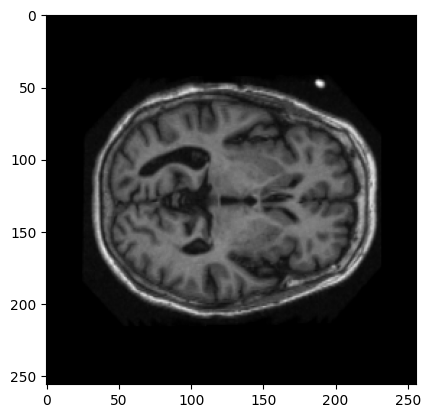

tensor([0, 1, 2, 3])


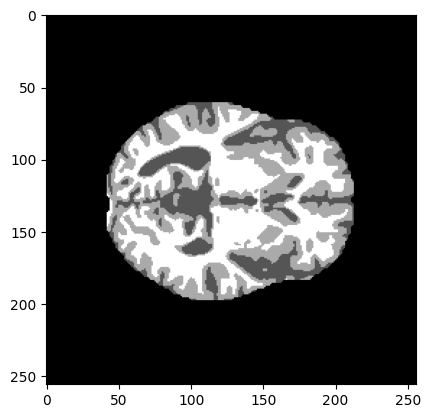

In [4]:
for img, seg in train_dataloader:
    print(img.shape, seg.shape)
    plt.imshow(img[0, 0], cmap='gray')
    plt.show()
    plt.imshow(seg[0, 0], cmap='gray')
    print(torch.unique(seg[0, 0]))
    break

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=4, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

net=UNet().cuda()
summary(net, input_size = (16, 1, 256, 256))


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [16, 4, 256, 256]         --
├─DoubleConv: 1-1                             [16, 64, 256, 256]        --
│    └─Sequential: 2-1                        [16, 64, 256, 256]        --
│    │    └─Conv2d: 3-1                       [16, 64, 256, 256]        576
│    │    └─BatchNorm2d: 3-2                  [16, 64, 256, 256]        128
│    │    └─ReLU: 3-3                         [16, 64, 256, 256]        --
│    │    └─Conv2d: 3-4                       [16, 64, 256, 256]        36,864
│    │    └─BatchNorm2d: 3-5                  [16, 64, 256, 256]        128
│    │    └─ReLU: 3-6                         [16, 64, 256, 256]        --
├─Down: 1-2                                   [16, 128, 128, 128]       --
│    └─Sequential: 2-2                        [16, 128, 128, 128]       --
│    │    └─MaxPool2d: 3-7                    [16, 64, 128, 128]        --
│    │    └─D

In [6]:
class DSCLoss(nn.Module):
    def __init__(self):
        super(DSCLoss, self).__init__()

    def forward(self, logits, target, smooth=True):
        C = logits.shape[1]
        if smooth:
            logits = F.softmax(logits, 1)
        else:
            logits = F.one_hot(torch.argmax(logits, 1), num_classes=C)
        C = logits.shape[1]
        target_tensor = F.one_hot(target.long(), num_classes=C)

        intersection = (logits * target_tensor).sum(0)
        loss = 2 * intersection / (logits.sum(0) + target_tensor.sum(0))
        return 1 - loss.mean()

In [7]:
optimizer = optim.Adam(net.parameters(), lr=1e-4)
criterion = DSCLoss()

In [8]:
def run_epoch(net, dataloader, update=True):
    total_num, total_loss, total_score = 0, 0, 0
    for now_step, batch_data in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()
        raw_img, seg_img = batch_data
        raw_img = raw_img.to(DEVICE)
        seg_img = seg_img.to(DEVICE).long()

        logits = net(raw_img)
        logits = torch.permute(logits, [0, 2, 3, 1]).reshape([-1, 4])

        loss = criterion(logits, seg_img.view([-1]), smooth=True)
        score = 1 - criterion(logits, seg_img.view([-1]), smooth=False)

        if update:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * len(raw_img)
        total_score += score.item() * len(raw_img)
        total_num += len(raw_img)

    return total_loss / total_num, total_score / total_num

In [9]:
for epoch in range(1):
    net.train()
    train_loss, train_DSC = run_epoch(net, train_dataloader, update=True)
    net.eval()
    valid_loss, valid_DSC = run_epoch(net, valid_dataloader, update=False)
    print('epoch {:>3d}: train loss: {:6.4f} DSC: {:6.4f} valid loss: {:6.4f} DSC: {:6.4f}'.format(
        epoch, train_loss, train_DSC, valid_loss, valid_DSC))
    # Save
    torch.save(net, 'UNet.pt')


100%|██████████| 140/140 [02:19<00:00,  1.00it/s]


epoch   0: train loss: 0.1399 DSC: 0.9454 valid loss: 0.0514 DSC: 0.9652


100%|██████████| 140/140 [02:40<00:00,  1.15s/it]


epoch   1: train loss: 0.0377 DSC: 0.9703 valid loss: 0.0399 DSC: 0.9645


100%|██████████| 140/140 [02:46<00:00,  1.19s/it]


epoch   2: train loss: 0.0290 DSC: 0.9739 valid loss: 0.0317 DSC: 0.9702


100%|██████████| 140/140 [02:40<00:00,  1.15s/it]


epoch   3: train loss: 0.0250 DSC: 0.9765 valid loss: 0.0326 DSC: 0.9685


100%|██████████| 140/140 [02:40<00:00,  1.14s/it]


epoch   4: train loss: 0.0227 DSC: 0.9782 valid loss: 0.0321 DSC: 0.9685


100%|██████████| 140/140 [02:40<00:00,  1.14s/it]


epoch   5: train loss: 0.0212 DSC: 0.9795 valid loss: 0.0288 DSC: 0.9716


100%|██████████| 140/140 [02:41<00:00,  1.15s/it]


epoch   6: train loss: 0.0199 DSC: 0.9806 valid loss: 0.0277 DSC: 0.9726


100%|██████████| 140/140 [02:40<00:00,  1.15s/it]


epoch   7: train loss: 0.0190 DSC: 0.9814 valid loss: 0.0277 DSC: 0.9726


 12%|█▏        | 140/1208 [08:34<1:05:27,  3.68s/it]


KeyboardInterrupt: 

In [11]:
# Calculate score
total_num, total_DSC = 0, np.zeros([4])
for now_step, batch_data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    optimizer.zero_grad()
    raw_img, seg_img = batch_data
    raw_img = raw_img.to(DEVICE)
    seg_img = seg_img.to(DEVICE).long()
    with torch.no_grad():
        logits = net(raw_img)
        logits = torch.permute(logits, [0, 2, 3, 1]).reshape([-1, 4])
        logits = F.one_hot(torch.argmax(logits, 1), num_classes=4)
        target_tensor = F.one_hot(seg_img.view([-1]).long(), num_classes=4)
        intersection = (logits * target_tensor).sum(0)
        DSC = 2 * intersection / (logits.sum(0) + target_tensor.sum(0))
    total_DSC += DSC.cpu().detach().numpy() * len(raw_img)
    total_num += len(raw_img)
print("DSC for each label:", total_DSC / total_num)

 12%|█▏        | 8/68 [00:12<01:36,  1.60s/it]

  0%|          | 0/68 [00:02<?, ?it/s]


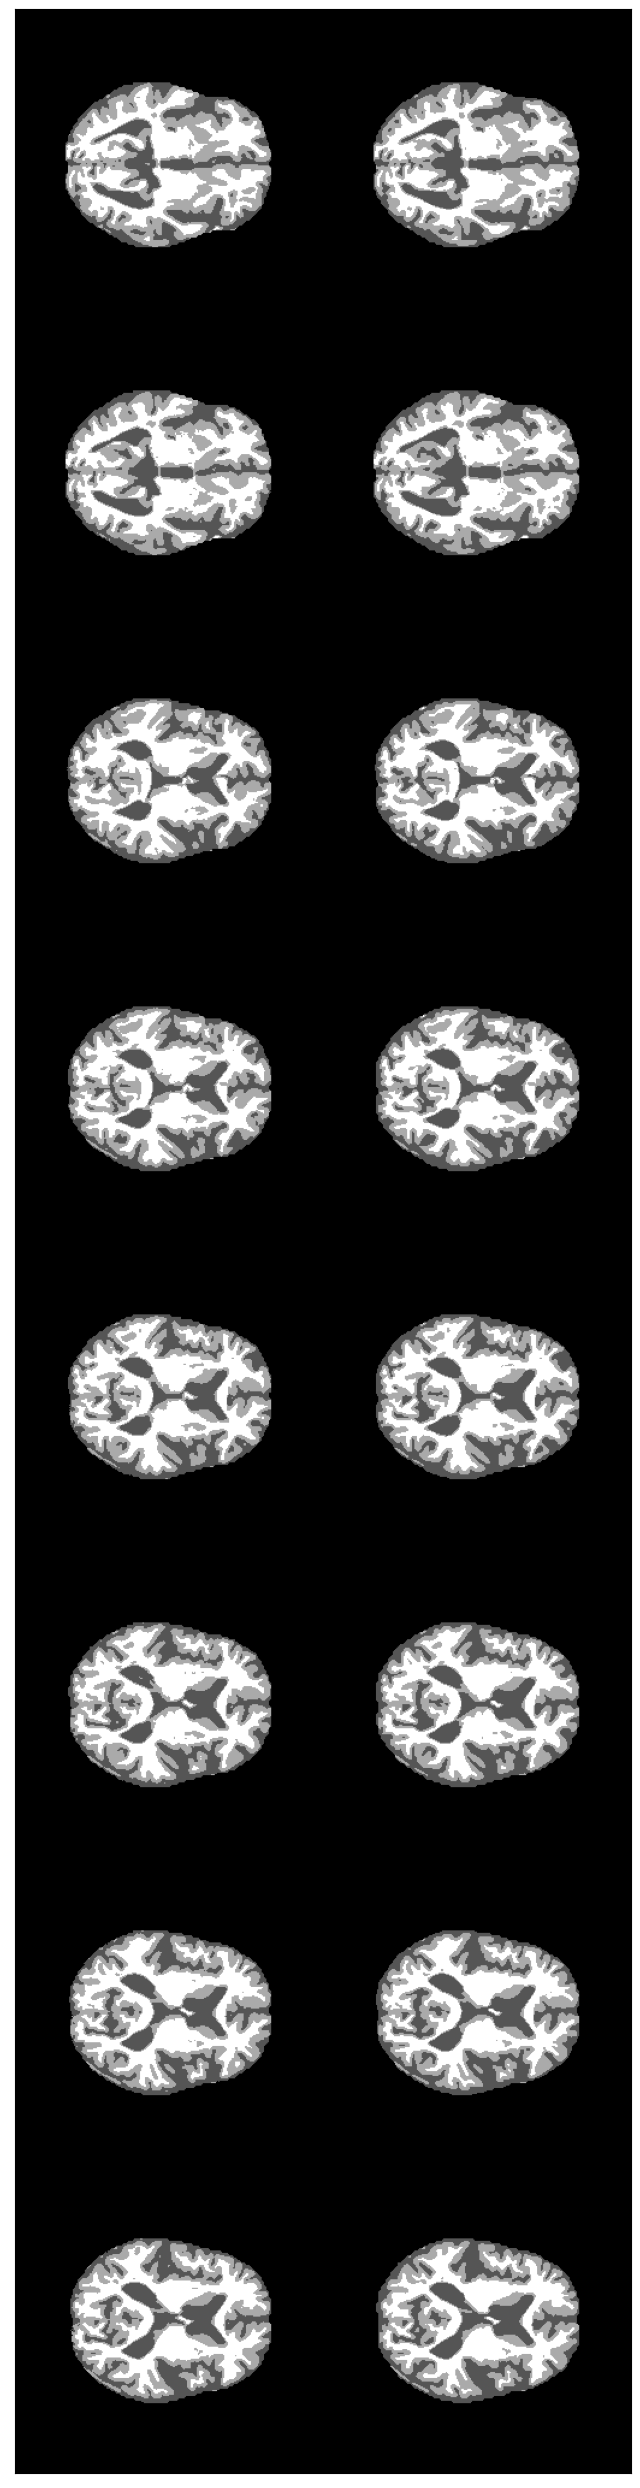

In [ ]:
# Visualize
for now_step, batch_data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    optimizer.zero_grad()
    raw_img, seg_img = batch_data
    raw_img = raw_img.to(DEVICE)
    seg_img = seg_img.to(DEVICE).long()
    logits = torch.argmax(net(raw_img), 1, keepdim=True)

    out = np.zeros([256*8, 256*2])
    for i, (A, B) in enumerate(zip(logits, seg_img)):
        out[i*256:(i+1)*256, 0:256] = A[0].cpu().detach().numpy()
        out[i*256:(i+1)*256, 256:] = B[0].cpu().detach().numpy()

    fig, ax = plt.subplots(figsize=(32, 32))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(out, cmap='gray')
    break

# Left one is predicted and right one is ground truth.
